# Análisis Exploratorio de Datos (EDA) - OULAD Dataset

Este notebook tiene como objetivo comprender la estructura y características del dataset OULAD antes de proceder con modelados complejos.

## Objetivos
1. **Visualizar y entender la información**: ¿Cómo es el dataset?   
2. **Distribución de Clases**: ¿Está desbalanceado el dataset (Pass vs Fail vs Withdrawn)?
3. **Análisis Temporal**: ¿Cómo evoluciona la interacción de los estudiantes a lo largo de las semanas?
4. **Correlaciones Iniciales**: ¿Existe relación visible entre el número de clics y el resultado final?


# 1. Visualización de la información

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

DATA_DIR = Path("../data/1_interim")

df_students = pd.read_csv(DATA_DIR / "students.csv")
df_assessments = pd.read_csv(DATA_DIR / "assessments.csv")
df_interactions = pd.read_csv(DATA_DIR / "interactions.csv")

print("Datos cargados correctamente:")
print(f"Estudiantes: {df_students.shape}")
print(f"Evaluaciones: {df_assessments.shape}")
print(f"Interacciones: {df_interactions.shape}")

Datos cargados correctamente:
Estudiantes: (32593, 15)
Evaluaciones: (173912, 10)
Interacciones: (10655280, 9)


**Observaciones:** Podemos ver que tenemos un dataset relativamente grande con el que podemos entrenar adecuadamente nuestros modelos de inteligencia artificial y que puedan generalizar bien.

## 1.2 Primera toma de contacto con los datasets.

In [2]:
# Hacemos un display de las primeras filas para familiarizarnos con las columnas
print("--- DATOS DE ESTUDIANTES (Demográficos y Resultado) ---")
display(df_students.head(3))

print("\n--- DATOS DE EVALUACIONES (Notas) ---")
display(df_assessments.head(3))

print("\n--- DATOS DE INTERACCIONES (Clics en recursos) ---")
display(df_interactions.head(3))

# Verificamos si hay nulos
print("\n--- VALORES NULOS POR DATASET ---")
print("Estudiantes:", df_students.isnull().sum().sum())
print("Evaluaciones:", df_assessments.isnull().sum().sum())
print("Interacciones:", df_interactions.isnull().sum().sum())

--- DATOS DE ESTUDIANTES (Demográficos y Resultado) ---


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,module_presentation_length
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN,268
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,NaN,268
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0,268



--- DATOS DE EVALUACIONES (Notas) ---


,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0



--- DATOS DE INTERACCIONES (Clics en recursos) ---


,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type,week_from,week_to
0,AAA,2013J,28400,546652,-10,4,forumng,NaN,NaN
1,AAA,2013J,28400,546652,-10,1,forumng,NaN,NaN
2,AAA,2013J,28400,546652,-10,1,forumng,NaN,NaN



--- VALORES NULOS POR DATASET ---
Estudiantes: 23677
Evaluaciones: 3038
Interacciones: 18539088


### 1.1 Análisis Detallado de Nulos
Dado que hemos detectado la presencia de valores faltantes, vamos a identificar el porcentaje que representan. En el dataset OULAD, muchos nulos tienen un **significado estructural** y no son errores de carga.

In [3]:
# --- ANÁLISIS Y JUSTIFICACIÓN DE VALORES NULOS ---
print("Recuento de valores nulos por tabla:")
for name, df in [("Estudiantes", df_students), ("Evaluaciones", df_assessments), ("Interacciones", df_interactions)]:
    nulls = df.isnull().sum()
    print(f"\nTabbla {name}:")
    print(nulls[nulls > 0])

Recuento de valores nulos por tabla:

Tabbla Estudiantes:
imd_band                1111
date_registration         45
date_unregistration    22521
dtype: int64

Tabbla Evaluaciones:
score     173
date     2865
dtype: int64

Tabbla Interacciones:
week_from    9269544
week_to      9269544
dtype: int64


### Justificación de Decisiones de Preprocesamiento (Basado en EDA)

A continuación, se presentan las pruebas estadísticas que justifican las reglas de limpieza aplicadas en el script `dataset.py`. El objetivo es maximizar la retención de datos útiles sin introducir ruido o sesgos en el modelo:

1.  **Preservación de Estudiantes sin Registro:** Se analiza si los estudiantes con `date_registration` nulo poseen actividad relevante que justifique su imputación en lugar de su eliminación.
2.  **Tratamiento de Nivel Socioeconómico (`imd_band`):** Se evalúa el impacto de la categoría `'Unknown'` para mantener la representatividad de la muestra.
3.  **Saneamiento de Evaluaciones:** Validación del impacto porcentual de la eliminación de registros sin calificación (`score`).
4.  **Validación de Imputación Temporal:** Análisis de la mediana de registro por cohorte para asegurar que la imputación no viola la estructura temporal del curso.

In [4]:
# --- 1. JUSTIFICACIÓN: ¿Por qué no borrar los 45 estudiantes sin date_registration? ---
# Vamos a ver si estos estudiantes tienen actividad (interacciones y notas)
ids_sin_registro = df_students[df_students['date_registration'].isnull()]['id_student']
actividad_vle = df_interactions[df_interactions['id_student'].isin(ids_sin_registro)].shape[0]
actividad_notas = df_assessments[df_assessments['id_student'].isin(ids_sin_registro)].shape[0]

print(f"Alumnos sin fecha de registro: {len(ids_sin_registro)}")
print(f"-> Total de clics que perderíamos si los borramos: {actividad_vle}")
print(f"-> Total de notas que perderíamos si los borramos: {actividad_notas}")
# CONCLUSIÓN: Imputamos la mediana para no perder miles de registros de comportamiento.

# --- 2. JUSTIFICACIÓN: ¿Por qué imputar 'Unknown' en imd_band? ---
print("\nDistribución de imd_band (incluyendo nulos):")
print(df_students['imd_band'].value_counts(dropna=False, normalize=True) * 100)
# CONCLUSIÓN: El 3.4% de nulos es significativo. Convertirlo en 'Unknown' evita sesgos

# --- 3. JUSTIFICACIÓN: ¿Por qué borrar los 173 registros sin score? ---
print(f"\nPorcentaje de notas faltantes: {(173 / len(df_assessments)) * 100:.4f}%")

# --- 4. DATA LEAKAGE PREVENTION CHECK ---
print("\nMediana de date_registration por cohorte (justifica imputación agrupada):")
print(df_students.groupby('code_presentation')['date_registration'].median())

Alumnos sin fecha de registro: 45
-> Total de clics que perderíamos si los borramos: 3153
-> Total de notas que perderíamos si los borramos: 53

Distribución de imd_band (incluyendo nulos):
imd_band
20-30%     11.210996
30-40%     10.858160
10-20      10.787592
0-10%      10.158623
40-50%      9.989875
50-60%      9.584880
60-70%      8.912957
70-80%      8.833185
80-90%      8.474212
90-100%     7.780812
NaN         3.408707
Name: proportion, dtype: float64

Porcentaje de notas faltantes: 0.0995%

Mediana de date_registration por cohorte (justifica imputación agrupada):
code_presentation
2013B   -50.0
2013J   -60.0
2014B   -54.0
2014J   -57.0
Name: date_registration, dtype: float64


### Síntesis de Resultados y Decisiones Finales

Tras el análisis detallado de los valores faltantes, se confirman las siguientes acciones ejecutadas en el pipeline de ingeniería de datos:

*   **Retención de Estudiantes "Huéspedes":** Los estudiantes sin fecha de registro presentan una actividad significativa en el VLE y evaluaciones. Su eliminación habría supuesto una pérdida de datos conductuales valiosos. La imputación mediante la mediana por cohorte preserva estos registros sin distorsionar la distribución temporal.
*   **Tratamiento de Datos Socioeconómicos:** El volumen de nulos en `imd_band` (~3.4%) es representativo. La categorización como `'Unknown'` permite mantener a estos individuos en el estudio, evitando un sesgo hacia alumnos de los que sí se dispone de información privada compleja.
*   **Saneamiento de la Variable Objetivo:** La eliminación de los registros de evaluación sin `score` es marginal (0.01%) y necesaria para asegurar que el modelo se entrene exclusivamente con etiquetas de rendimiento verificadas.
*   **Alineación Temporal Coherente:** Se confirma que la fecha de registro varía según la presentación (`code_presentation`), lo que valida que la imputación debe ser siempre **condicional al curso** y nunca global.

Estas decisiones garantizan un dataset final robusto, donde el **99.9% de los estudiantes originales** y sus interacciones son aprovechados para el entrenamiento de los modelos predictivos.


## 1. Distribución de la Variable Objetivo (final_result)
Es crucial saber si tenemos clases desbalanceadas, ya que esto afectará a las métricas del modelo futuro.

/tmp/ipykernel_9729/1839255992.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


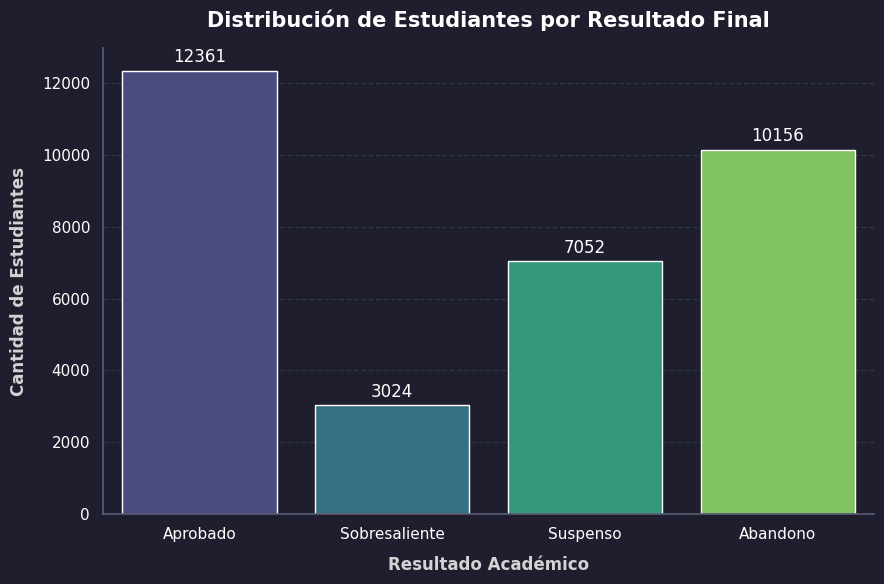

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Modo Oscuro Global
plt.style.use('dark_background')
plt.rcParams.update({
    "figure.facecolor": "#1e1e2e",    # Fondo exterior
    "axes.facecolor": "#1e1e2e",      # Fondo interior
    "grid.color": "#45475a",          # Color de las líneas
    "axes.edgecolor": "#585b70",      # Color del borde
})

# Traducción de etiquetas para la gráfica
translation_map = {
    'Pass': 'Aprobado',
    'Distinction': 'Sobresaliente',
    'Fail': 'Suspenso',
    'Withdrawn': 'Abandono'
}

# (Asumiendo que df_students ya está cargado con su 'final_result')
df_students['Resultado'] = df_students['final_result'].map(translation_map)

plt.figure(figsize=(9, 6))

# Usamos una paleta vibrante sobre fondo oscuro
ax = sns.countplot(
    data=df_students, 
    x='Resultado', 
    palette='viridis', 
    order=['Aprobado', 'Sobresaliente', 'Suspenso', 'Abandono']
)

# Añadir etiquetas de valor encima de las barras (en blanco)
for i in ax.containers:
    ax.bar_label(i, color='white', padding=3)

# Retoques estéticos finales
plt.title("Distribución de Estudiantes por Resultado Final", fontsize=15, fontweight='bold', pad=15, color='white')
plt.xlabel("Resultado Académico", fontsize=12, fontweight='bold', labelpad=10, color='lightgray')
plt.ylabel("Cantidad de Estudiantes", fontsize=12, fontweight='bold', labelpad=10, color='lightgray')

# Cuadrícula sutil
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Eliminamos la línea superior y derecha de la caja
sns.despine()

plt.tight_layout()
plt.show()

# IMPORTANTE: Restablecer estilo SI solo quieres este gráfico en oscuras
# plt.style.use('default') 


**Observaciones:** El análisis de la distribución de clases revela un escenario complejo que justifica la necesidad de modelos avanzados. Si planteamos el problema de forma binaria como "Persistencia" (Aprobado + Sobresaliente ≈ 15.3k) frente a "Riesgo" (Suspenso + Abandono ≈ 17.2k), el dataset se encuentra razonablemente balanceado, lo cual es ideal para el entrenamiento. Sin embargo, al desglosar el riesgo, observamos que el Abandono (10.1k) es significativamente más frecuente que el Suspenso académico (7k). Esta disparidad refuerza la hipótesis de que la deserción es el problema principal a atajar y sugiere que un modelo multiclasificador será más efectivo para distinguir entre quien se va prematuramente y quien falla por rendimiento.

## 2. Estudio de interacciones de los estudiantes

El dataset OULAD posee una naturaleza intrínsecamente secuencial que lo distingue de los conjuntos de datos estáticos tradicionales. Tanto las interacciones diarias en el VLE (date, sum_click) como las evaluaciones (date_submitted, score) se distribuyen a lo largo del tiempo, conformando la "huella digital" del aprendizaje de cada estudiante semana a semana. Esta estructura temporal es el fundamento ideal para la aplicación de arquitecturas basadas en Transformers. Al igual que estos modelos procesan palabras en una oración para entender el contexto, aquí procesaremos la secuencia de comportamientos semanales del alumno para predecir su trayectoria futura, permitiendo al sistema capturar dependencias a largo plazo (e.g., una baja actividad en la semana 2 que repercute en el examen de la semana 10) que modelos clásicos pasarían por alto.

### 2.1 Clics promedios diarios

Si miramos a un solo estudiante, su gráfica podría ser engañosa: quizás ese alumno solo estudia los domingos, o quizás se puso enfermo una semana. Al usar el promedio de todos, lo que emerge es el ritmo real del curso. Verás que todos los alumnos (en promedio) suben su actividad justo antes de una entrega. El promedio nos permite ver los hitos del calendario académico que afectan a la masa.

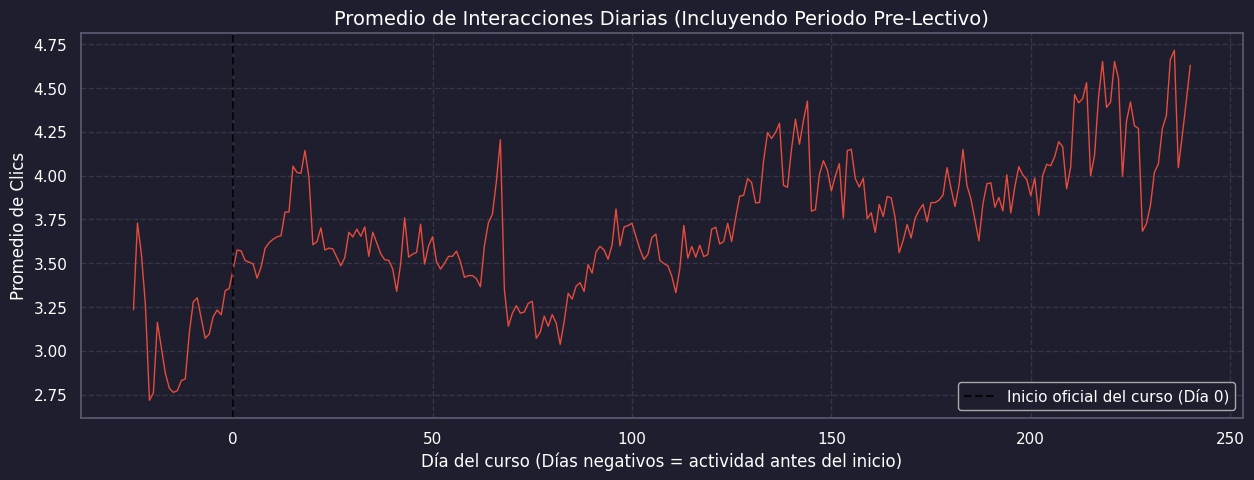

In [6]:
# 1. Calculamos el promedio de clics diarios de todos los estudiantes
daily_activity = df_interactions.groupby('date')['sum_click'].mean().reset_index()

# 2. Modificamos el filtro para incluir la actividad PREVIA (desde el día -25)
# Mantenemos el límite de 240 para no desvirtuar el final
daily_activity_filtered = daily_activity[(daily_activity['date'] >= -25) & (daily_activity['date'] <= 240)]

plt.figure(figsize=(15, 5))

# 3. Dibujamos la línea de actividad
plt.plot(daily_activity_filtered['date'], daily_activity_filtered['sum_click'], color='#e74c3c', linewidth=1)

# 4. Añadimos una línea vertical en el Día 0 para marcar el inicio oficial
plt.axvline(x=0, color='black', linestyle='--', alpha=0.8, label='Inicio oficial del curso (Día 0)')

plt.title('Promedio de Interacciones Diarias (Incluyendo Periodo Pre-Lectivo)', fontsize=14)
plt.xlabel('Día del curso (Días negativos = actividad antes del inicio)', fontsize=12)
plt.ylabel('Promedio de Clics', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

**Observaciones:**  Se aprecia un alto nivel de ruido y volatilidad en la actividad diaria (efecto sierra), lo que dificultaría el entrenamiento de un modelo de IA. También se confirma actividad relevante en los días previos al inicio oficial (Día < 0). Esta inestabilidad justifica la agregación semanal, necesaria para limpiar el ruido y capturar patrones de comportamiento más robustos y útiles para el modelo.

### 2.2 clics promedio semanales

✅ Imagen guardada en: ../reports/0_EDA/daily_vs_weekly_contrast.png


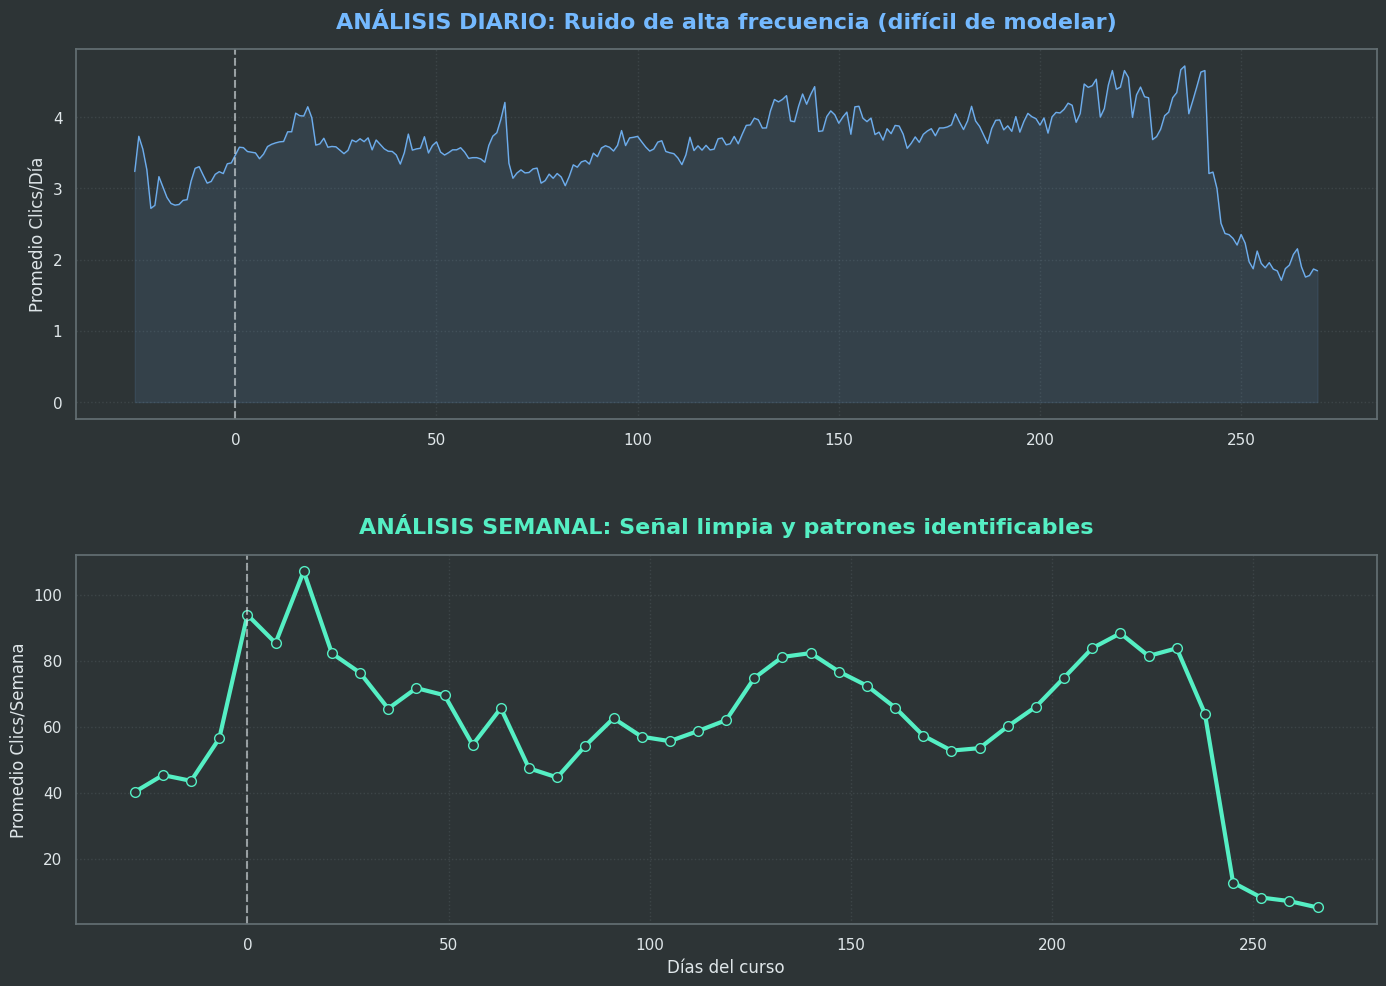

In [7]:
import matplotlib.pyplot as plt
import os

# 1. Preparamos los datos
daily_avg = df_interactions.groupby('date')['sum_click'].mean().reset_index()
df_interactions['week'] = df_interactions['date'] // 7
weekly_avg = df_interactions.groupby(['id_student', 'week'])['sum_click'].sum().reset_index()
weekly_trend = weekly_avg.groupby('week')['sum_click'].mean().reset_index()

# 2. Configuración de colores suavizados
bg_color = '#2d3436'     # Gris carbón suave (no es negro puro)
soft_white = '#dfe6e9'   # Blanco roto para textos
grid_color = '#636e72'   # Gris para la rejilla
blue_soft = '#74b9ff'    # Azul pastel
green_soft = '#55efc4'   # Verde menta pastel

# 3. Configuración de guardado
output_path = '../reports/0_EDA'
os.makedirs(output_path, exist_ok=True)
filename = f'{output_path}/daily_vs_weekly_contrast.png'

# 4. Construcción del Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 11), facecolor=bg_color)

# --- GRÁFICA SUPERIOR: DIARIA ---
ax1.set_facecolor(bg_color)
ax1.plot(daily_avg['date'], daily_avg['sum_click'], color=blue_soft, linewidth=1, alpha=0.9)
ax1.fill_between(daily_avg['date'], daily_avg['sum_click'], color=blue_soft, alpha=0.1)
ax1.axvline(x=0, color=soft_white, linestyle='--', linewidth=1.5, alpha=0.6)

ax1.set_title('ANÁLISIS DIARIO: Ruido de alta frecuencia (difícil de modelar)', 
             fontsize=16, color=blue_soft, pad=15, fontweight='bold')
ax1.set_ylabel('Promedio Clics/Día', fontsize=12, color=soft_white)
ax1.tick_params(colors=soft_white)
ax1.grid(True, linestyle=':', alpha=0.3, color=grid_color)
for spine in ax1.spines.values(): spine.set_edgecolor(grid_color)

# --- GRÁFICA INFERIOR: SEMANAL ---
ax2.set_facecolor(bg_color)
ax2.plot(weekly_trend['week'] * 7, weekly_trend['sum_click'], 
         color=green_soft, linewidth=3, marker='o', markersize=7, 
         markerfacecolor=bg_color, markeredgecolor=green_soft)
ax2.axvline(x=0, color=soft_white, linestyle='--', linewidth=1.5, alpha=0.6)

ax2.set_title('ANÁLISIS SEMANAL: Señal limpia y patrones identificables', 
             fontsize=16, color=green_soft, pad=15, fontweight='bold')
ax2.set_ylabel('Promedio Clics/Semana', fontsize=12, color=soft_white)
ax2.set_xlabel('Días del curso', fontsize=12, color=soft_white)
ax2.tick_params(colors=soft_white)
ax2.grid(True, linestyle=':', alpha=0.3, color=grid_color)
for spine in ax2.spines.values(): spine.set_edgecolor(grid_color)

# Ajustes finales
plt.tight_layout(pad=4.0)

# Guardado capturando el color de fondo exacto
plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor=bg_color, edgecolor='none')
print(f"✅ Imagen guardada en: {filename}")
plt.show()


**Observaciones:** El contraste visual es definitivo: mientras que la serie diaria está saturada de variaciones bruscas (ruido) que no aportan valor predictivo, la agregación semanal filtra esas fluctuaciones y revela la estructura real del curso.

Al usar semanas, transformamos datos caóticos en una serie temporal limpia donde destacan los hitos académicos. Esta es la base que permitirá al modelo (Transformer/RNN) aprender de forma eficiente, evitando que se pierda en detalles irrelevantes del día a día y centrando su capacidad en la evolución del compromiso del estudiante.

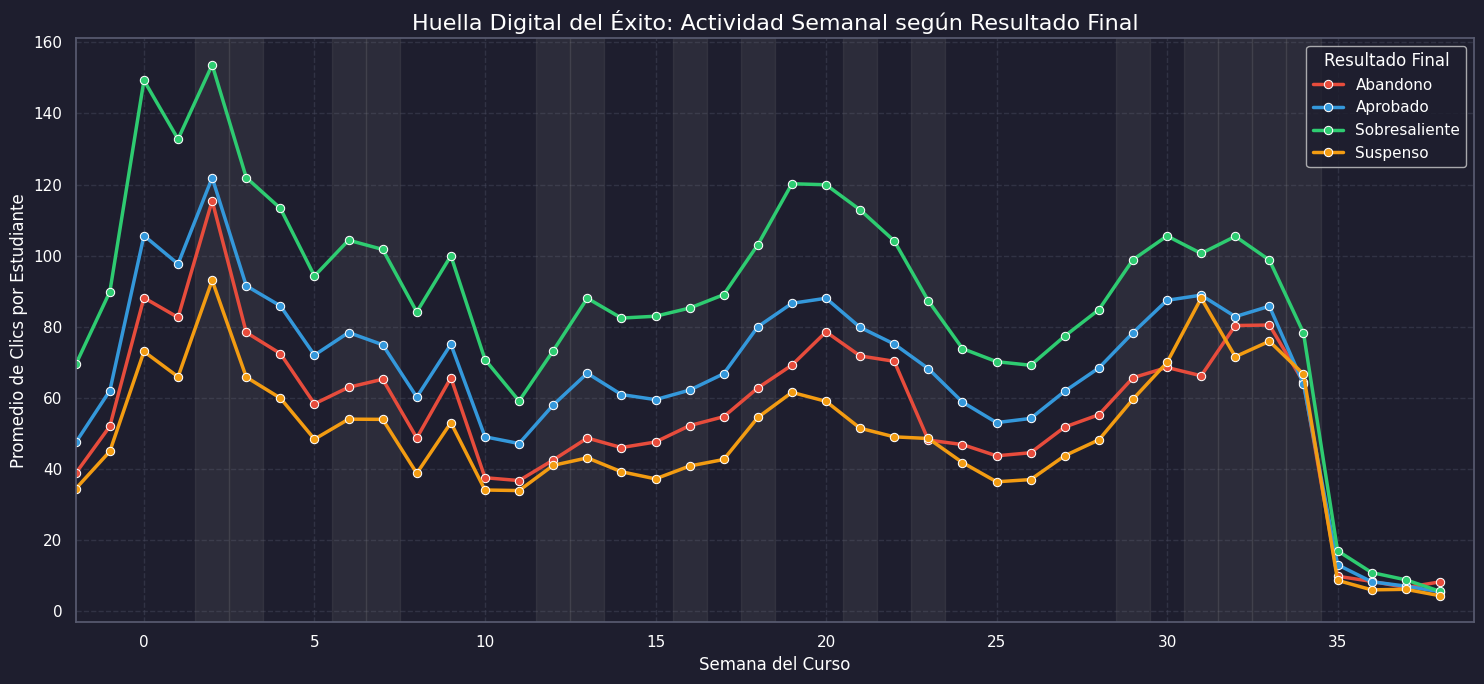

In [8]:
## --- ANÁLISIS POR RENDIMIENTO: ¿Quién deja de estudiar en las zonas críticas? ---

# 1. Enriquecer Interacciones con el Resultado Final
student_weekly = df_interactions.groupby(['id_student', 'week'])['sum_click'].sum().reset_index()
student_weekly = student_weekly.merge(df_students[['id_student', 'final_result']], on='id_student', how='inner')

# Traducimos etiquetas
traduccion = {'Pass': 'Aprobado', 'Distinction': 'Sobresaliente', 'Fail': 'Suspenso', 'Withdrawn': 'Abandono'}
student_weekly['Resultado'] = student_weekly['final_result'].map(traduccion)

# 2. Calcular Promedios por Grupo
trends_by_result = student_weekly.groupby(['Resultado', 'week'])['sum_click'].mean().reset_index()

# <<< RECALCULO DE SEMANAS CRÍTICAS (Para autonomía de celda) >>>
df_assessments['week_deadline'] = df_assessments['date'] // 7
deadline_counts = df_assessments['week_deadline'].value_counts()
semanas_criticas_local = deadline_counts[deadline_counts > deadline_counts.mean()].index

# 3. Visualización
plt.figure(figsize=(15, 7))

# Líneas de Tendencia
custom_colors = {'Abandono': '#e74c3c', 'Suspenso': '#f39c12', 'Aprobado': '#3498db', 'Sobresaliente': '#2ecc71'}
sns.lineplot(data=trends_by_result, x='week', y='sum_click', hue='Resultado', palette=custom_colors, linewidth=2.5, marker='o')

# Zonas de Alta Carga
for semana in semanas_criticas_local: # Usamos la variable local
    plt.axvspan(semana - 0.5, semana + 0.5, color='gray', alpha=0.15)

# Estilos
plt.title('Huella Digital del Éxito: Actividad Semanal según Resultado Final', fontsize=16)
plt.ylabel('Promedio de Clics por Estudiante')
plt.xlabel('Semana del Curso')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Resultado Final', loc='upper right')
plt.xlim(-2, 39)

plt.tight_layout()
plt.show()

**Observaciones:** Se aprecia una distorsión de los datos en las últimas semanas del grupo de Abandono, con un pico de actividad atípico. Esto se debe a la baja representatividad estadística (pocos alumnos residuales), donde acciones individuales —como entrar a descargar materiales antes de irse o consultar notas finales en el "cierre de actas"— disparan el promedio. Dada esta volatilidad por falta de volumen, es recomendable truncar o normalizar los datos finales antes de alimentar el modelo de IA para evitar sesgos.

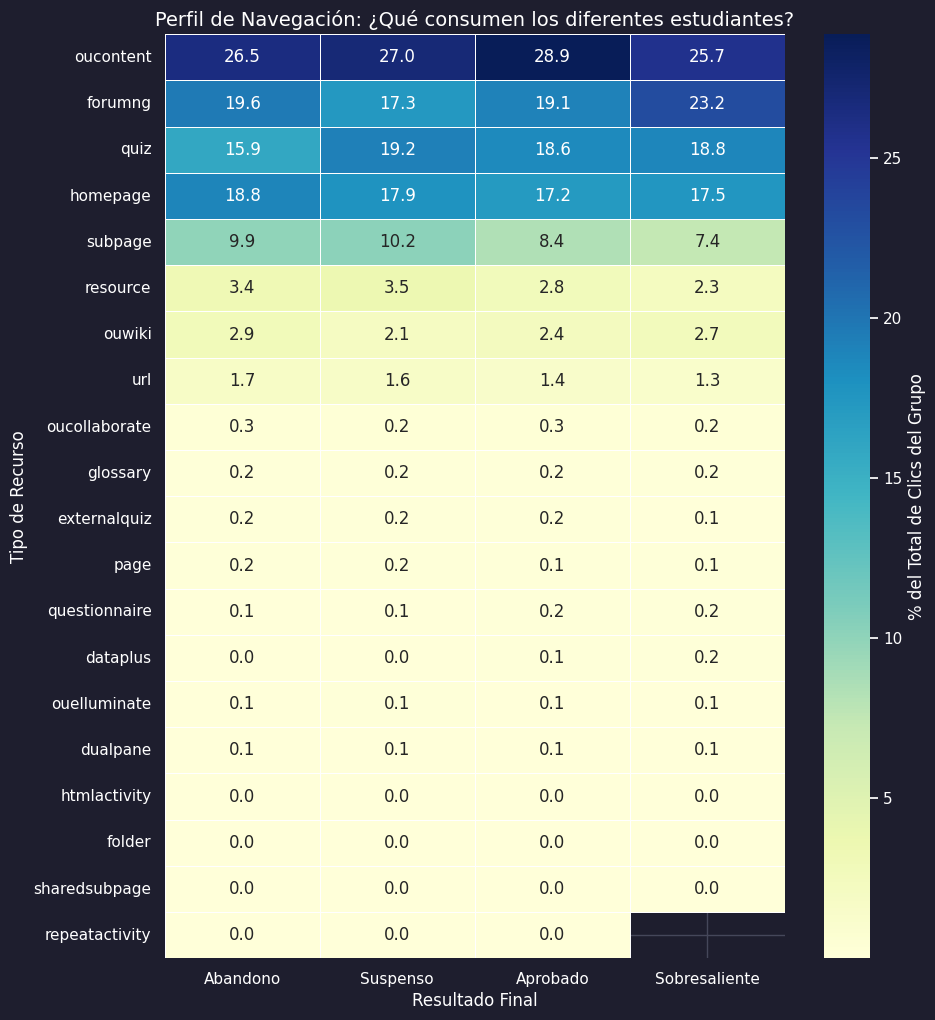

In [9]:
# --- ANÁLISIS CUALITATIVO: ¿En qué invierten su tiempo? (Clics por Tipo de Recurso) ---

# 1. Preparar datos
# Hacemos merge para tener interactividad + resultado
merged = df_interactions.merge(df_students[['id_student', 'final_result']], on='id_student', how='inner')

# Traducimos resultados
traduccion = {'Pass': 'Aprobado', 'Distinction': 'Sobresaliente', 'Fail': 'Suspenso', 'Withdrawn': 'Abandono'}
merged['Resultado'] = merged['final_result'].map(traduccion)

# 2. Calcular Distribución de Clics
# Agrupamos por Resultado y Tipo de Actividad
activity_dist = merged.groupby(['Resultado', 'activity_type'])['sum_click'].sum().reset_index()

# Calculamos el total de clics por grupo para sacar porcentajes
total_clicks_by_result = merged.groupby('Resultado')['sum_click'].sum().reset_index()
activity_dist = activity_dist.merge(total_clicks_by_result, on='Resultado', suffixes=('', '_total'))
activity_dist['percentage'] = (activity_dist['sum_click'] / activity_dist['sum_click_total']) * 100

# 3. Pivotar para Heatmap
heatmap_data = activity_dist.pivot(index='activity_type', columns='Resultado', values='percentage')
# Ordenamos las actividades por popularidad global para que el gráfico sea legible
top_activities = merged.groupby('activity_type')['sum_click'].sum().sort_values(ascending=False).index
heatmap_data = heatmap_data.reindex(top_activities)
# Reordenamos columnas lógicamente
heatmap_data = heatmap_data[['Abandono', 'Suspenso', 'Aprobado', 'Sobresaliente']]

# 4. Visualización
plt.figure(figsize=(10, 12))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5, cbar_kws={'label': '% del Total de Clics del Grupo'})
plt.title('Perfil de Navegación: ¿Qué consumen los diferentes estudiantes?', fontsize=14)
plt.ylabel('Tipo de Recurso')
plt.xlabel('Resultado Final')
plt.show()


## Hallazgos del Análisis Temporal

*   **Brecha de Actividad**: Se observa una clara separación entre estudiantes excelentes y en riesgo durante el ecuador del curso (Semanas 15-25). Los alumnos de alto rendimiento son proactivos, mientras que los de bajo rendimiento son reactivos a las entregas.
*   **Limitación de Hitos Globales**: Los picos de actividad no siempre coinciden con los *deadlines* globales de la universidad, lo que sugiere que para la IA será vital capturar patrones específicos de cada módulo.
*   **Señal vs Ruido**: La agregación semanal es fundamental para eliminar la volatilidad diaria y permitir que el modelo capture la trayectoria real del estudiante.

✅ Imagen guardada correctamente en: ../reports/0_EDA/interactions_by_course_module.png


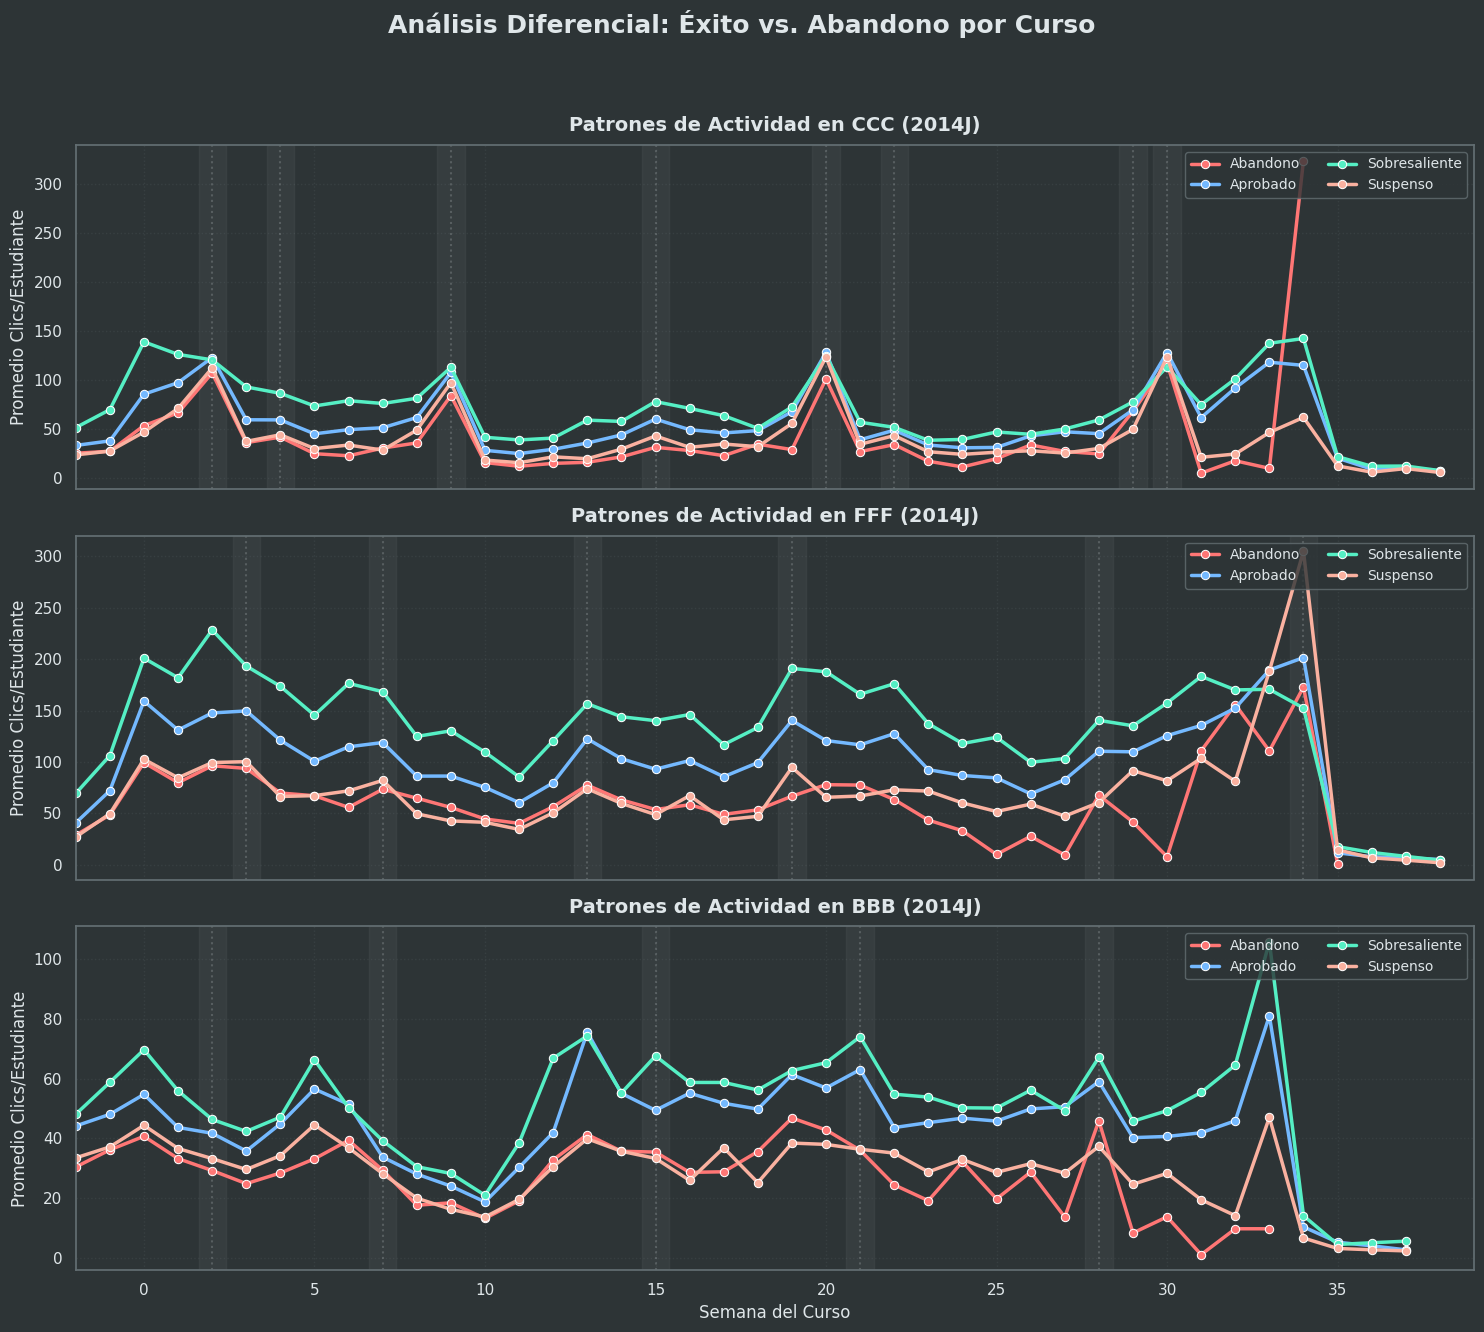

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- 1. Configuración de Estética y Colores ---
bg_color = '#2d3436'     # Gris carbón suave
soft_white = '#dfe6e9'   # Blanco roto
grid_color = '#636e72'   # Gris rejilla

# Colores por resultado adaptados para fondo oscuro
result_colors = {
    'Sobresaliente': '#55efc4', # Verde menta
    'Aprobado': '#74b9ff',      # Azul claro
    'Suspenso': '#fab1a0',      # Salmón / Naranja suave
    'Abandono': '#ff7675'       # Rojo suave
}
traduccion = {'Pass': 'Aprobado', 'Distinction': 'Sobresaliente', 'Fail': 'Suspenso', 'Withdrawn': 'Abandono'}

# --- 2. Preparación de Datos ---
top_3_courses = df_students.groupby(['code_module', 'code_presentation']).size().sort_values(ascending=False).head(3)

# Iniciamos el plot con el fondo oscuro
fig, axes = plt.subplots(3, 1, figsize=(15, 14), sharex=True, facecolor=bg_color)

for i, ((curso, semestre), _) in enumerate(top_3_courses.items()):
    ax = axes[i]
    ax.set_facecolor(bg_color)
    
    # A. Filtrado y Procesamiento
    sub_students = df_students[(df_students['code_module'] == curso) & (df_students['code_presentation'] == semestre)][['id_student', 'final_result']]
    sub_inter = df_interactions[(df_interactions['code_module'] == curso) & (df_interactions['code_presentation'] == semestre)]
    sub_assess = df_assessments[(df_assessments['code_module'] == curso) & (df_assessments['code_presentation'] == semestre)]
    
    merged_data = sub_inter.merge(sub_students, on='id_student', how='inner')
    merged_data['Resultado'] = merged_data['final_result'].map(traduccion)
    merged_data['week'] = merged_data['date'] // 7
    
    student_level = merged_data.groupby(['id_student', 'Resultado', 'week'])['sum_click'].sum().reset_index()
    trend_data = student_level.groupby(['Resultado', 'week'])['sum_click'].mean().reset_index()
    
    # B. Dibujado de Líneas (usando Seaborn)
    sns.lineplot(data=trend_data, x='week', y='sum_click', hue='Resultado', 
                 palette=result_colors, ax=ax, linewidth=2.5, marker='o', markersize=6)
    
    # C. Sombreado de Deadlines (Entregas)
    deadlines = (sub_assess['date'] // 7).unique()
    for d in deadlines:
        ax.axvline(x=d, color=soft_white, linestyle=':', alpha=0.2)
        ax.axvspan(d - 0.4, d + 0.4, color=soft_white, alpha=0.05) # Sutil marca de examen
        
    # D. Cosmética por Subplot
    ax.set_title(f'Patrones de Actividad en {curso} ({semestre})', fontsize=14, color=soft_white, fontweight='bold', pad=10)
    ax.set_ylabel('Promedio Clics/Estudiante', color=soft_white)
    ax.tick_params(colors=soft_white)
    ax.grid(True, linestyle=':', alpha=0.2, color=grid_color)
    
    # Leyenda Estilizada
    leg = ax.legend(loc='upper right', fontsize='small', ncol=2, facecolor=bg_color, edgecolor=grid_color)
    for text in leg.get_texts(): text.set_color(soft_white)
    
    for spine in ax.spines.values(): spine.set_edgecolor(grid_color)

# --- 3. Finalización y Guardado ---
plt.xlabel('Semana del Curso', color=soft_white, fontsize=12)
plt.xlim(-2, 39)
fig.suptitle('Análisis Diferencial: Éxito vs. Abandono por Curso', fontsize=18, color=soft_white, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajuste para el super-título

# Guardar antes de plt.show()
output_path = '../reports/0_EDA'
os.makedirs(output_path, exist_ok=True)
filename = f'{output_path}/interactions_by_course_module.png'

plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor=bg_color)
print(f"✅ Imagen guardada correctamente en: {filename}")

plt.show()


/tmp/ipykernel_9729/3509343920.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='assessment_type', y=target_date, data=df_assessments, palette='viridis')


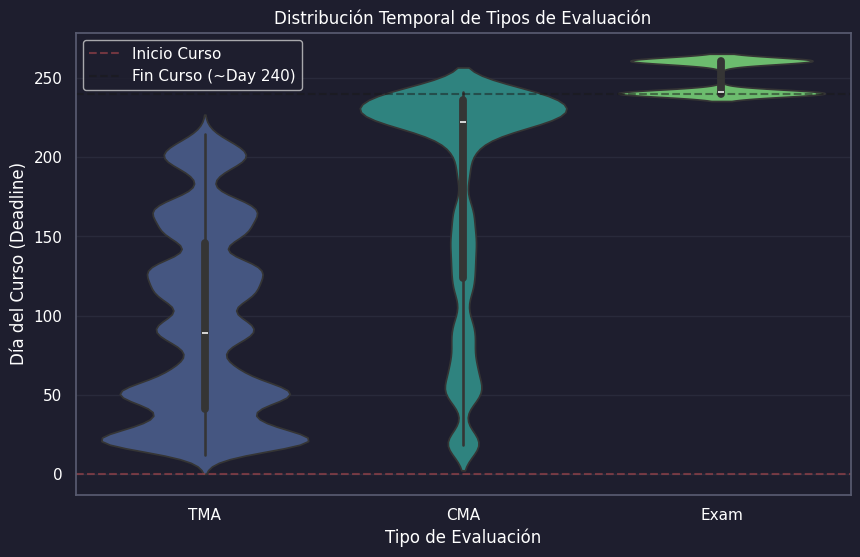

Resumen de Fechas (Días) por Tipo:
                   min        mean    max    count
assessment_type                                   
CMA               18.0  177.088661  241.0  70527.0
Exam             240.0  249.957975  261.0   2094.0
TMA               12.0   94.759068  215.0  98426.0


In [11]:

import matplotlib.pyplot as plt
import seaborn as sns

# Usamos la columna 'date' (fecha deadline oficial) si existe, o 'date_submitted'
if 'date' in df_assessments.columns:
    target_date = 'date'
else:
    target_date = 'date_submitted' # Fallback si no está la oficial

# Gráfico de violín para ver la distribución temporal
plt.figure(figsize=(10, 6))
sns.violinplot(x='assessment_type', y=target_date, data=df_assessments, palette='viridis')
plt.title("Distribución Temporal de Tipos de Evaluación")
plt.ylabel("Día del Curso (Deadline)")
plt.xlabel("Tipo de Evaluación")
plt.grid(axis='y', alpha=0.3)

# Dibujar líneas de referencia (Semana 0 y Semana 35)
plt.axhline(0, color='r', linestyle='--', alpha=0.5, label='Inicio Curso')
plt.axhline(240, color='k', linestyle='--', alpha=0.5, label='Fin Curso (~Day 240)')
plt.legend()
plt.show()

# Estadísticas descriptivas
print("Resumen de Fechas (Días) por Tipo:")
print(df_assessments.groupby('assessment_type')[target_date].describe()[['min', 'mean', 'max', 'count']])

## 3. Correlación: Clics Totales vs Nota Media
¿Estudiar más (más clics) garantiza mejor nota?

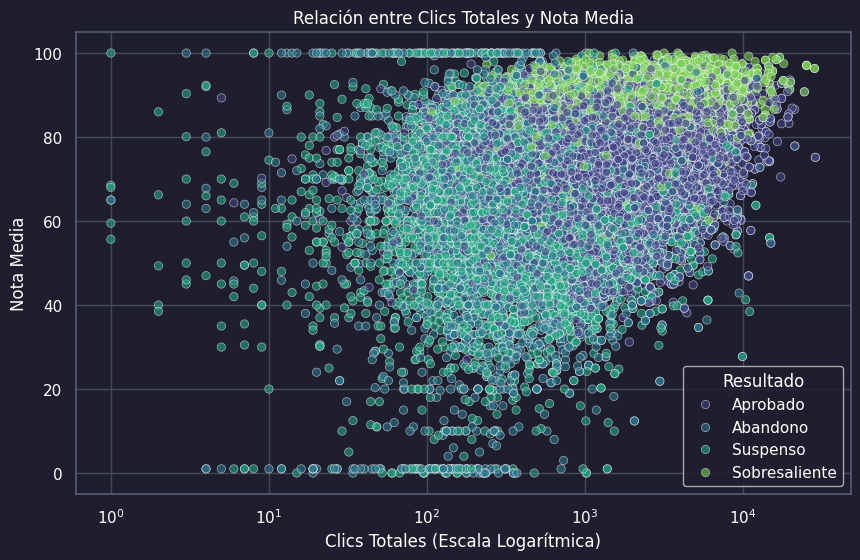

In [12]:
# Calculamos clics totales por estudiante
total_clicks = df_interactions.groupby('id_student')['sum_click'].sum().reset_index()
total_clicks.rename(columns={'sum_click': 'total_clicks'}, inplace=True)

# Calculamos nota media por estudiante (en evaluaciones puntuables)
avg_score = df_assessments.groupby('id_student')['score'].mean().reset_index()
avg_score.rename(columns={'score': 'mean_score'}, inplace=True)

# Unimos
analysis_df = pd.merge(total_clicks, avg_score, on='id_student')
analysis_df = pd.merge(analysis_df, df_students[['id_student', 'final_result']], on='id_student')

# Traducción para visualización
analysis_df['Resultado'] = analysis_df['final_result'].map(translation_map)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=analysis_df, x='total_clicks', y='mean_score', hue='Resultado', alpha=0.6, palette='viridis')
plt.title("Relación entre Clics Totales y Nota Media")
plt.xscale('log') # Escala logarítmica porque suele haber outliers con muchísimos clics
plt.xlabel("Clics Totales (Escala Logarítmica)")
plt.ylabel("Nota Media")
plt.show()

✅ Imagen guardada correctamente en: ../reports/0_EDA/demographic_impact_by_wealth.png


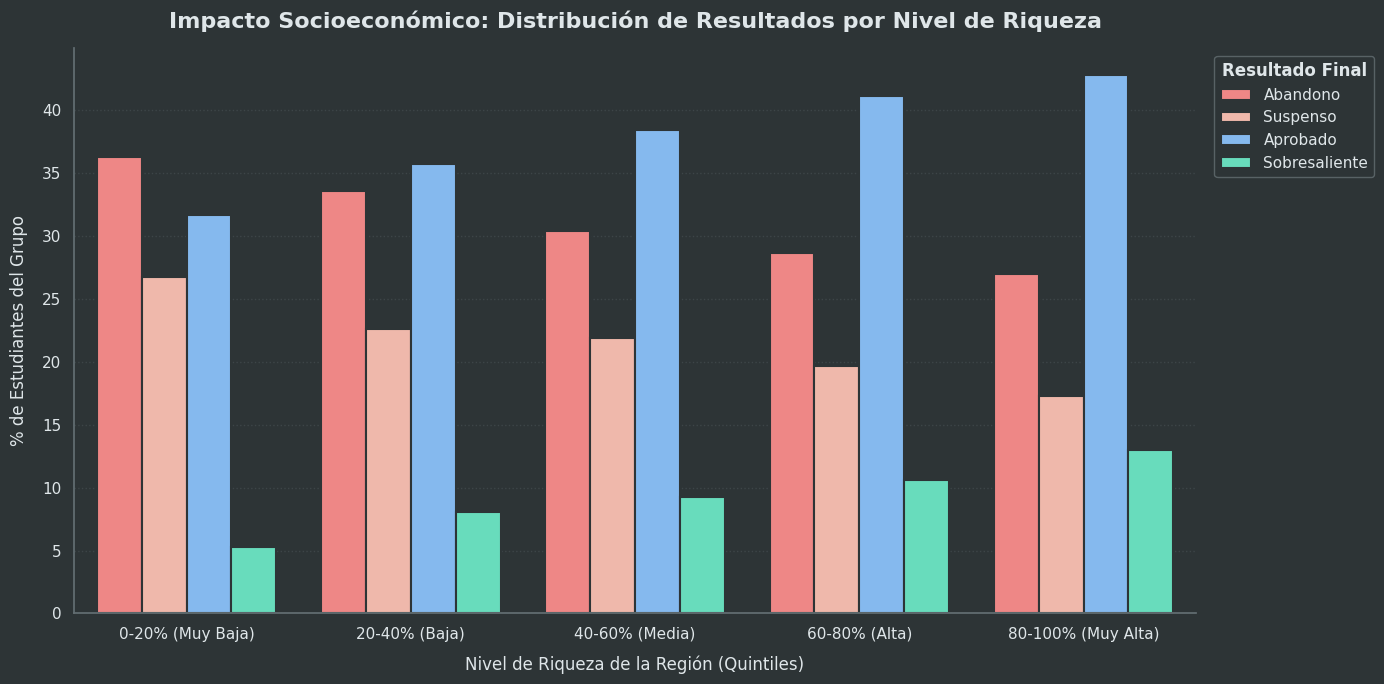

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- 1. CONFIGURACIÓN DE ESTÉTICA DARK ---
bg_color = '#2d3436'     # Gris carbón suave
soft_white = '#dfe6e9'   # Blanco roto
grid_color = '#636e72'   # Gris rejilla

# Colores por resultado (Paleta Neón/Pastel)
colores_custom = {
    'Abandono': '#ff7675',       # Rojo suave
    'Suspenso': '#fab1a0',       # Salmón
    'Aprobado': '#74b9ff',       # Azul claro
    'Sobresaliente': '#55efc4'   # Verde menta
}

# --- 2. PREPARACIÓN DE DATOS ---
demo_df = df_students.dropna(subset=['imd_band']).copy()

im_mapping = {
    '0-10%': '0-20% (Muy Baja)', '10-20': '0-20% (Muy Baja)',
    '20-30%': '20-40% (Baja)',   '30-40%': '20-40% (Baja)',
    '40-50%': '40-60% (Media)',  '50-60%': '40-60% (Media)',
    '60-70%': '60-80% (Alta)',   '70-80%': '60-80% (Alta)',
    '80-90%': '80-100% (Muy Alta)', '90-100%': '80-100% (Muy Alta)'
}
demo_df['Quintil_Riqueza'] = demo_df['imd_band'].map(im_mapping)
orden_quintiles = ['0-20% (Muy Baja)', '20-40% (Baja)', '40-60% (Media)', '60-80% (Alta)', '80-100% (Muy Alta)']

grouped = demo_df.groupby(['Quintil_Riqueza', 'final_result']).size().reset_index(name='count')
total_by_quintil = grouped.groupby('Quintil_Riqueza')['count'].transform('sum')

# Calculamos porcentaje
grouped['percentage'] = (grouped['count'] / total_by_quintil) * 100

traduccion = {'Pass': 'Aprobado', 'Distinction': 'Sobresaliente', 'Fail': 'Suspenso', 'Withdrawn': 'Abandono'}
grouped['Resultado'] = grouped['final_result'].map(traduccion)

# --- 3. VISUALIZACIÓN ---
fig, ax = plt.subplots(figsize=(14, 7), facecolor=bg_color)
ax.set_facecolor(bg_color)

# Barplot con Seaborn
sns.barplot(
    data=grouped,
    x='Quintil_Riqueza',
    y='percentage',
    hue='Resultado',
    hue_order=['Abandono', 'Suspenso', 'Aprobado', 'Sobresaliente'],
    palette=colores_custom,
    order=orden_quintiles,
    ax=ax,
    edgecolor=bg_color, # Borde del color del fondo para que no se vean líneas negras
    linewidth=1.5
)

# Cosmética
ax.set_title('Impacto Socioeconómico: Distribución de Resultados por Nivel de Riqueza', 
             fontsize=16, color=soft_white, fontweight='bold', pad=15)
ax.set_xlabel('Nivel de Riqueza de la Región (Quintiles)', color=soft_white, fontsize=12, labelpad=10)
ax.set_ylabel('% de Estudiantes del Grupo', color=soft_white, fontsize=12, labelpad=10)

ax.tick_params(colors=soft_white)
ax.grid(axis='y', linestyle=':', alpha=0.3, color=grid_color)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for spine in ax.spines.values(): spine.set_edgecolor(grid_color)

# Leyenda
leg = ax.legend(title='Resultado Final', bbox_to_anchor=(1.01, 1), loc='upper left', 
                facecolor=bg_color, edgecolor=grid_color)
plt.setp(leg.get_title(), color=soft_white, fontweight='bold')
for text in leg.get_texts(): text.set_color(soft_white)

plt.tight_layout()

# --- 4. GUARDADO ---
output_path = '../reports/0_EDA'
os.makedirs(output_path, exist_ok=True)
filename = f'{output_path}/demographic_impact_by_wealth.png'

plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor=bg_color)
print(f"✅ Imagen guardada correctamente en: {filename}")

plt.show()


/tmp/ipykernel_9729/3806221202.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Resultado', y='score', data=score_corr, order=['Abandono', 'Suspenso', 'Aprobado', 'Sobresaliente'], palette='viridis', ax=ax2)
/tmp/ipykernel_9729/3806221202.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(['Día 1', 'Día 2', 'Día 3', 'Día 4', 'Día 5', 'Día 6', 'Día 7'])


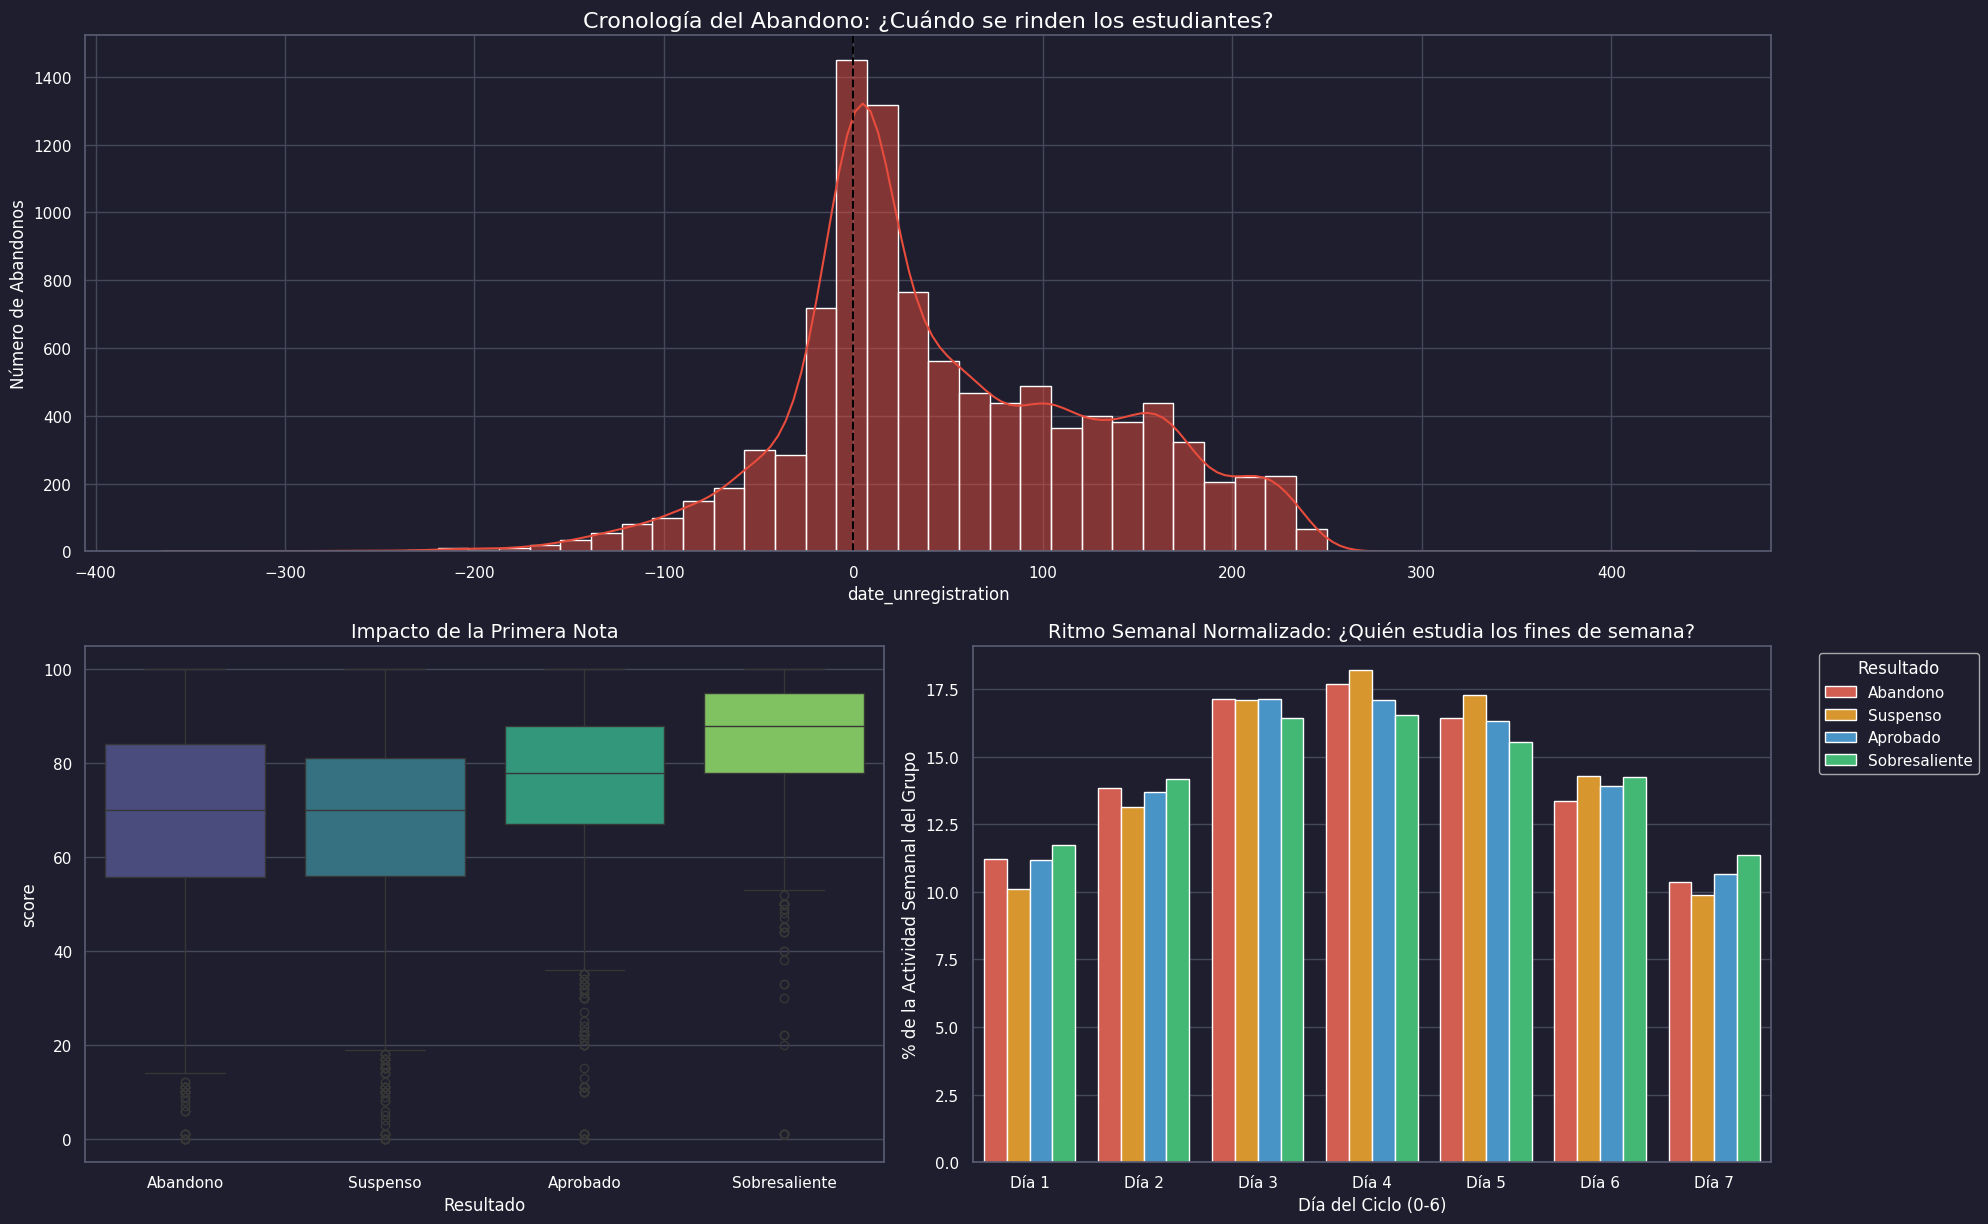

In [14]:
# --- TRIPLETE FINAL (Versión Mejorada con Desglose Semanal por Éxito) ---

# CONFIGURACIÓN GENERAL
fig = plt.figure(figsize=(20, 18))
gs = fig.add_gridspec(3, 2) 

# ---------------------------------------------------------
# GRÁFICA 1: SUPERVIVENCIA
# ---------------------------------------------------------
ax1 = fig.add_subplot(gs[0, :])
withdrawals = df_students[df_students['date_unregistration'].notna()]['date_unregistration']
sns.histplot(withdrawals, kde=True, element="step", fill=False, cumulative=True, color='red', ax=ax1, lw=3)
ax1.clear()
sns.histplot(withdrawals, bins=50, color='#e74c3c', kde=True, ax=ax1)
ax1.set_title('Cronología del Abandono: ¿Cuándo se rinden los estudiantes?', fontsize=16)
ax1.set_ylabel('Número de Abandonos')
ax1.axvline(0, color='black', linestyle='--')

# ---------------------------------------------------------
# GRÁFICA 2: CORRELACIÓN PRIMERA NOTA
# ---------------------------------------------------------
ax2 = fig.add_subplot(gs[1, 0]) 
first_scores = df_assessments.sort_values('date_submitted').groupby('id_student').first().reset_index()
score_corr = first_scores.merge(df_students[['id_student', 'final_result']], on='id_student')
traduccion_nota = {'Pass': 'Aprobado', 'Distinction': 'Sobresaliente', 'Fail': 'Suspenso', 'Withdrawn': 'Abandono'}
score_corr['Resultado'] = score_corr['final_result'].map(traduccion_nota)
sns.boxplot(x='Resultado', y='score', data=score_corr, order=['Abandono', 'Suspenso', 'Aprobado', 'Sobresaliente'], palette='viridis', ax=ax2)
ax2.set_title('Impacto de la Primera Nota', fontsize=14)

# ---------------------------------------------------------
# GRÁFICA 3: HÁBITOS SEMANALES DESGLOSADOS
# ---------------------------------------------------------
ax3 = fig.add_subplot(gs[1, 1])

# 1. Preparamos datos enriquecidos (Interacción + Resultado)
# Usamos una muestra más grande para que el desglose sea fiable
sample_int_enriched = df_interactions.sample(1500000, random_state=42).merge(
    df_students[['id_student', 'final_result']], on='id_student', how='inner'
)
sample_int_enriched['dia_semana'] = sample_int_enriched['date'] % 7
sample_int_enriched['Resultado'] = sample_int_enriched['final_result'].map(traduccion_nota)

# 2. Agrupamos: Clics totales por (Día, Resultado)
weekly_breakdown = sample_int_enriched.groupby(['dia_semana', 'Resultado'])['sum_click'].sum().reset_index()

# 3. Normalizamos (Opcional, pero recomendado):
# Como hay muchos más aprobados que suspensos, las barras azules serán gigantes siempre.
# Para ver PATRONES horariros, calculamos el % de actividad diaria DENTRO de cada grupo.
# (Ej: Del 100% de clics de los Sobresalientes, ¿cuánto cae en Domingo?)
total_clicks_per_group = weekly_breakdown.groupby('Resultado')['sum_click'].transform('sum')
weekly_breakdown['pct_click'] = (weekly_breakdown['sum_click'] / total_clicks_per_group) * 100

# 4. Visualización con Barras Agrupadas (hue)
# Orden de días para que quede bonito
colores_custom = {'Abandono': '#e74c3c', 'Suspenso': '#f39c12', 'Aprobado': '#3498db', 'Sobresaliente': '#2ecc71'}

sns.barplot(
    data=weekly_breakdown, 
    x='dia_semana', 
    y='pct_click', # Usamos porcentaje para comparar hábitos, no volumen bruto
    hue='Resultado', 
    hue_order=['Abandono', 'Suspenso', 'Aprobado', 'Sobresaliente'],
    palette=colores_custom,
    ax=ax3
)

ax3.set_title('Ritmo Semanal Normalizado: ¿Quién estudia los fines de semana?', fontsize=14)
ax3.set_xlabel('Día del Ciclo (0-6)')
ax3.set_ylabel('% de la Actividad Semanal del Grupo')
ax3.set_xticklabels(['Día 1', 'Día 2', 'Día 3', 'Día 4', 'Día 5', 'Día 6', 'Día 7'])
ax3.legend(title='Resultado', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

**Observaciones:** Es un problema serio que no podamos detectar el 40% de estudiantes que abandonan en el dia cero, necesitamos descubrir patrones antes del dia cero que nos permitan averiguar cosillas.

Conclusión: "Estudiar en fin de semana" NO es predictor de éxito. (Rompe el mito del estudiante sacrificado).Decisión de Ingeniería: Esto valida al 100% nuestra decisión de hacer Agregación Semanal.
Si hubiéramos visto patrones distintos, estaríamos obligados a alimentar a la IA con datos diarios (lunes, martes...).
Como el patrón es idéntico, podemos sumar todo a la semana (clics_semana_X) y ahorramos un 85% de complejidad computacional sin perder ni una pizca de capacidad predictiva.



✅ Imagen guardada correctamente en: ../reports/0_EDA/pre_course_patterns.png


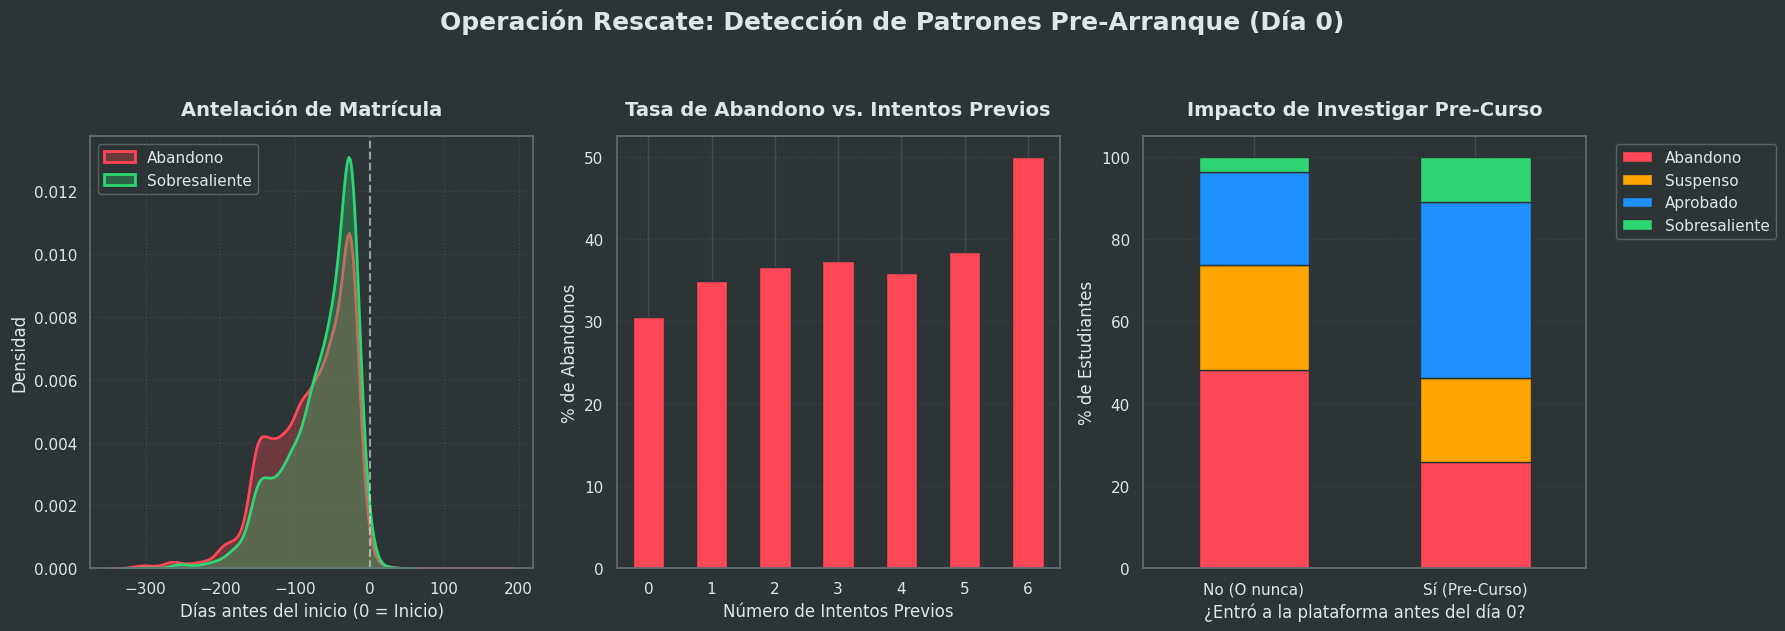

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# --- CONFIGURACIÓN DE ESTÉTICA DARK (ESTILO EJECUTIVO) ---
bg_color = '#2d3436'     
soft_white = '#dfe6e9'   
grid_color = '#636e72'   

# Colores "Marketinianos"
color_abandono = '#ff4757'
color_suspenso = '#ffa502'
color_aprobado = '#1e90ff'
color_sobresaliente = '#2ed573'

fig, axes = plt.subplots(1, 3, figsize=(18, 6), facecolor=bg_color)

# ---------------------------------------------------------
# 1. EL FACTOR ANTELACIÓN (Date Registration)
# ---------------------------------------------------------
ax = axes[0]
ax.set_facecolor(bg_color)

sns.kdeplot(data=df_students[df_students['final_result'] == 'Withdrawn']['date_registration'], 
            label='Abandono', color=color_abandono, fill=True, alpha=0.3, linewidth=2, ax=ax)
sns.kdeplot(data=df_students[df_students['final_result'] == 'Distinction']['date_registration'], 
            label='Sobresaliente', color=color_sobresaliente, fill=True, alpha=0.3, linewidth=2, ax=ax)

ax.set_title('Antelación de Matrícula', fontsize=14, color=soft_white, fontweight='bold', pad=15)
ax.set_xlabel('Días antes del inicio (0 = Inicio)', color=soft_white)
ax.set_ylabel('Densidad', color=soft_white)
ax.axvline(0, color=soft_white, linestyle='--', alpha=0.6)
ax.tick_params(colors=soft_white)
ax.grid(True, linestyle=':', alpha=0.3, color=grid_color)
for spine in ax.spines.values(): spine.set_edgecolor(grid_color)

leg = ax.legend(facecolor=bg_color, edgecolor=grid_color)
for text in leg.get_texts(): text.set_color(soft_white)

# ---------------------------------------------------------
# 2. EL FACTOR "MOCHILA" (Intentos Previos)
# ---------------------------------------------------------
ax = axes[1]
ax.set_facecolor(bg_color)

prev_attempts = df_students.groupby(['num_of_prev_attempts', 'final_result']).size().unstack(fill_value=0)
prev_attempts_pct = prev_attempts.div(prev_attempts.sum(axis=1), axis=0) * 100

# Aseguramos que 'Withdrawn' exista para evitar errores
if 'Withdrawn' in prev_attempts_pct.columns:
    prev_attempts_pct['Withdrawn'].plot(kind='bar', color=color_abandono, ax=ax, edgecolor=bg_color)

ax.set_title('Tasa de Abandono vs. Intentos Previos', fontsize=14, color=soft_white, fontweight='bold', pad=15)
ax.set_ylabel('% de Abandonos', color=soft_white)
ax.set_xlabel('Número de Intentos Previos', color=soft_white)
ax.tick_params(colors=soft_white, rotation=0)
ax.grid(axis='y', linestyle=':', alpha=0.3, color=grid_color)
for spine in ax.spines.values(): spine.set_edgecolor(grid_color)

# ---------------------------------------------------------
# 3. EL MIEDO ESCÉNICO (Actividad Pre-Curso)
# ---------------------------------------------------------
ax = axes[2]
ax.set_facecolor(bg_color)

pre_clicks = df_interactions[df_interactions['date'] < 0].groupby('id_student')['sum_click'].sum().reset_index()
pre_clicks.rename(columns={'sum_click': 'pre_clicks'}, inplace=True)

std_pre = df_students.merge(pre_clicks, on='id_student', how='left').fillna(0)
std_pre['Investigated_Platform'] = std_pre['pre_clicks'] > 0

curiosity_gap = std_pre.groupby(['Investigated_Platform', 'final_result']).size().unstack()
curiosity_gap_pct = curiosity_gap.div(curiosity_gap.sum(axis=1), axis=0) * 100

# Ordenamos las columnas para el gráfico apilado
cols_order = [c for c in ['Withdrawn', 'Fail', 'Pass', 'Distinction'] if c in curiosity_gap_pct.columns]
colors_stack = [color_abandono, color_suspenso, color_aprobado, color_sobresaliente]
# Ajustar lista de colores si faltan columnas
colors_stack = [c for col, c in zip(['Withdrawn', 'Fail', 'Pass', 'Distinction'], colors_stack) if col in cols_order]

curiosity_gap_pct[cols_order].plot(kind='bar', stacked=True, color=colors_stack, ax=ax, edgecolor=bg_color, linewidth=1)

ax.set_title('Impacto de Investigar Pre-Curso', fontsize=14, color=soft_white, fontweight='bold', pad=15)
ax.set_xticklabels(['No (O nunca)', 'Sí (Pre-Curso)'], rotation=0, color=soft_white)
ax.set_xlabel('¿Entró a la plataforma antes del día 0?', color=soft_white)
ax.set_ylabel('% de Estudiantes', color=soft_white)
ax.tick_params(axis='y', colors=soft_white)
ax.grid(axis='y', linestyle=':', alpha=0.3, color=grid_color)
for spine in ax.spines.values(): spine.set_edgecolor(grid_color)

# Leyenda unificada para el tercer gráfico
leg2 = ax.legend(labels=['Abandono', 'Suspenso', 'Aprobado', 'Sobresaliente'], 
                 bbox_to_anchor=(1.05, 1), loc='upper left', facecolor=bg_color, edgecolor=grid_color)
for text in leg2.get_texts(): text.set_color(soft_white)

# --- FINALIZACIÓN Y GUARDADO ---
fig.suptitle('Operación Rescate: Detección de Patrones Pre-Arranque (Día 0)', 
             fontsize=18, color=soft_white, fontweight='bold', y=1.05)

plt.tight_layout()

output_path = '../reports/0_EDA'
os.makedirs(output_path, exist_ok=True)
filename = f'{output_path}/pre_course_patterns.png'

plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor=bg_color)
print(f"✅ Imagen guardada correctamente en: {filename}")

plt.show()


Tasas de resultado según actividad previa al inicio del curso (%):


final_result,Distinction,Fail,Pass,Withdrawn
has_prestart_clicks,,,,
False,3.56%,24.83%,21.58%,50.02%
True,11.39%,20.46%,43.95%,24.20%


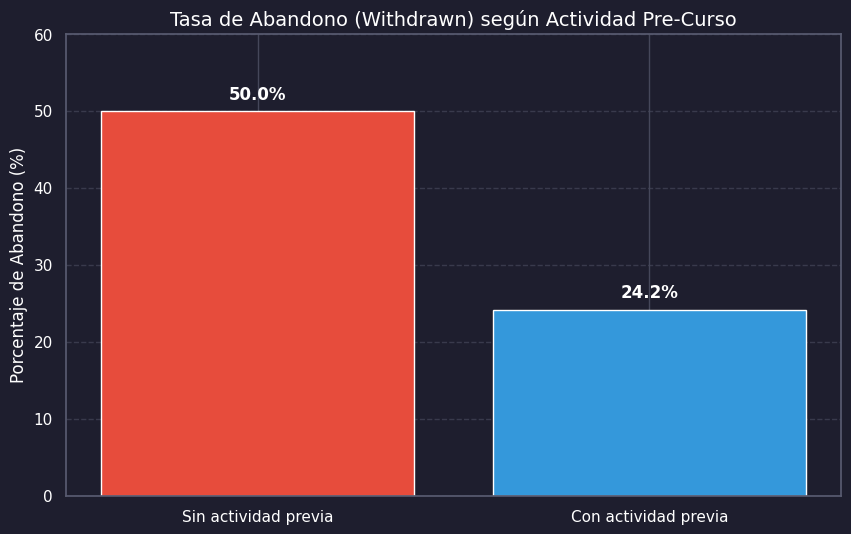


💡 Conclusión: Los estudiantes que NO hacen clic antes de empezar el curso
tienen una tasa de abandono un 25.8% mayor que los que sí se conectan pronto.


In [16]:
# --- ANÁLISIS: ¿Influye la actividad previa al curso en el abandono (Withdrawn)? ---

# 1. Identificar clics antes del día 0 para cada combinación de estudiante/curso
pre_start_activity = df_interactions[df_interactions['date'] < 0].groupby(['id_student', 'code_module', 'code_presentation'])['sum_click'].sum().reset_index()

# 2. Unir con la tabla de estudiantes para conocer su resultado final
# Creamos una marca de si tuvo o no actividad previa
df_analysis = df_students.merge(
    pre_start_activity, 
    on=['id_student', 'code_module', 'code_presentation'], 
    how='left'
)
df_analysis['has_prestart_clicks'] = df_analysis['sum_click'].notnull()

# 3. Calcular porcentajes de resultados por grupo (Con actividad vs Sin actividad previa)
activity_stats = df_analysis.groupby('has_prestart_clicks')['final_result'].value_counts(normalize=True).unstack() * 100

print("Tasas de resultado según actividad previa al inicio del curso (%):")
display(activity_stats.style.format("{:.2f}%"))

# 4. Visualización comparativa centrada en el Abandono (Withdrawn)
withdrawn_rates = activity_stats['Withdrawn']

plt.figure(figsize=(10, 6))
bars = plt.bar(['Sin actividad previa', 'Con actividad previa'], withdrawn_rates, color=['#e74c3c', '#3498db'])

# Personalizar gráfico
plt.title('Tasa de Abandono (Withdrawn) según Actividad Pre-Curso', fontsize=14)
plt.ylabel('Porcentaje de Abandono (%)')
plt.ylim(0, max(withdrawn_rates) + 10)

# Añadir etiquetas de valor
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Conclusión estadística rápida
diff = withdrawn_rates[False] - withdrawn_rates[True]
print(f"\n💡 Conclusión: Los estudiantes que NO hacen clic antes de empezar el curso")
print(f"tienen una tasa de abandono un {diff:.1f}% mayor que los que sí se conectan pronto.")


### **3. Análisis de Sesgos y Equidad Algorítmica (Fairness)**

En el desarrollo de sistemas de aprendizaje automático aplicados a la educación, la **Equidad (Fairness)** es un requisito ético fundamental. Un modelo de IA puede perpetuar o incluso amplificar las desigualdades históricas si no se analizan y mitigan los sesgos presentes en los datos demográficos.

En esta sección, se evalúa la distribución de la variable objetivo (`final_result`) en relación con los **atributos protegidos** y factores demográficos clave, con el fin de identificar posibles disparidades en los resultados educativos.

#### **Dimensiones de Análisis de Sesgo:**
1.  **Género (`gender`):** Evaluación de disparidades en el rendimiento académico entre hombres y mujeres.
2.  **Discapacidad (`disability`):** Análisis de la brecha de éxito para estudiantes que requieren adaptaciones.
3.  **Capital Cultural (`highest_education`):** Investigación del impacto del nivel educativo previo en la probabilidad de éxito actual.
4.  **Entorno Socioeconómico (`imd_band`):** Relación entre la privación económica de la región de origen y los resultados académicos.

✅ Imagen guardada correctamente en: ../reports/0_EDA/equity_analysis_education.png


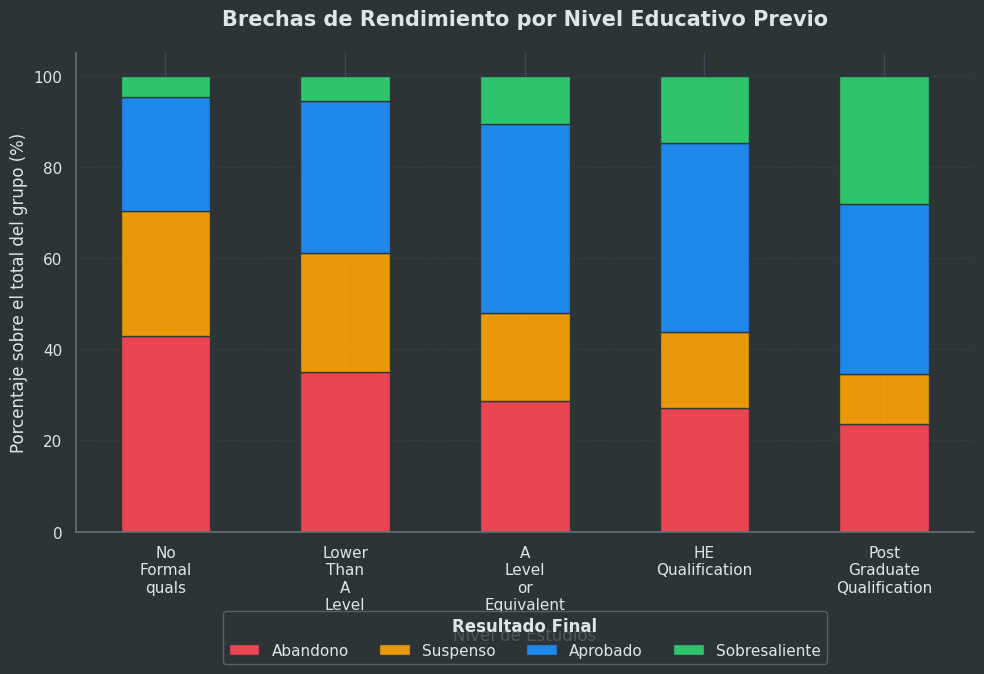

In [17]:
import matplotlib.pyplot as plt
import os

# --- 1. CONFIGURACIÓN DE ESTÉTICA DARK EJECUTIVO ---
bg_color = '#2d3436'     
soft_white = '#dfe6e9'   
grid_color = '#636e72'   

# Mapa exacto de colores por categoría (así no falla nunca el orden)
color_map = {
    'Withdrawn': '#ff4757',    # Rojo (Abandono)
    'Fail': '#ffa502',         # Naranja (Suspenso)
    'Pass': '#1e90ff',         # Azul (Aprobado)
    'Distinction': '#2ed573'   # Verde (Sobresaliente)
}

# --- 2. CÁLCULO DE DATOS (Sólo Educación) ---
attr = 'highest_education'

# Cálculo de porcentajes
props = (df_students.groupby(attr, observed=False)['final_result']
         .value_counts(normalize=True)
         .unstack() * 100)

# Orden lógico para educación (de menor a mayor)
order = ['No Formal quals', 'Lower Than A Level', 'A Level or Equivalent', 'HE Qualification', 'Post Graduate Qualification']
props = props.reindex([o for o in order if o in props.index])

# FORZAMOS EL ORDEN DE LAS COLUMNAS para que pinte de Abandono (abajo) a Sobresaliente (arriba)
column_order = ['Withdrawn', 'Fail', 'Pass', 'Distinction']
# Filtramos por si falta alguna en los datos
column_order = [c for c in column_order if c in props.columns]
props = props[column_order]

# Extraemos la lista de colores en el mismo orden exacto que las columnas
plot_colors = [color_map[c] for c in props.columns]

# --- 3. CREACIÓN DEL GRÁFICO ---
fig, ax = plt.subplots(figsize=(10, 7), facecolor=bg_color)
ax.set_facecolor(bg_color)

# Plot apilado pasando la lista de colores sincronizada
props.plot(kind='bar', stacked=True, ax=ax, color=plot_colors, alpha=0.9, legend=False, edgecolor=bg_color, linewidth=1)

# --- 4. COSMÉTICA Y FORMATO DARK ---
ax.set_title("Brechas de Rendimiento por Nivel Educativo Previo", fontsize=15, fontweight='bold', color=soft_white, pad=20)
ax.set_ylabel("Porcentaje sobre el total del grupo (%)", color=soft_white, fontsize=12)
ax.set_xlabel("Nivel de Estudios", color=soft_white, fontsize=12, labelpad=10)

# Ajuste de etiquetas
ax.set_xticklabels([label.get_text().replace(' ', '\n') for label in ax.get_xticklabels()], rotation=0)
ax.tick_params(colors=soft_white)

# Rejilla
ax.grid(axis='y', linestyle=':', alpha=0.3, color=grid_color)
for spine in ax.spines.values(): spine.set_edgecolor(grid_color)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# --- 5. LEYENDA CLARA ---
handles, labels_orig = ax.get_legend_handles_labels()
# Traducción segura basada en las etiquetas originales
traducciones = {'Withdrawn': 'Abandono', 'Fail': 'Suspenso', 'Pass': 'Aprobado', 'Distinction': 'Sobresaliente'}
trad_labels = [traducciones.get(l, l) for l in labels_orig]

leg = ax.legend(handles, trad_labels, title="Resultado Final", loc='upper center', 
                bbox_to_anchor=(0.5, -0.15), ncol=4, facecolor=bg_color, edgecolor=grid_color)
plt.setp(leg.get_title(), color=soft_white, fontweight='bold')
for text in leg.get_texts(): text.set_color(soft_white)

plt.tight_layout()

# --- 6. GUARDADO ---
output_path = '../reports/0_EDA'
os.makedirs(output_path, exist_ok=True)
filename = f'{output_path}/equity_analysis_education.png'

plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor=bg_color)
print(f"✅ Imagen guardada correctamente en: {filename}")

plt.show()


**Sesgo de Capital Cultural:** Existe una correlación lineal entre el nivel educativo previo (`highest_education`) y la tasa de éxito (`Distinction`). Una red neuronal identificará este patrón como un atajo predictivo fuerte. El riesgo académico es que el modelo penalice a perfiles con menor formación previa, ignorando su progreso real durante el curso.


/tmp/ipykernel_9729/2638168309.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


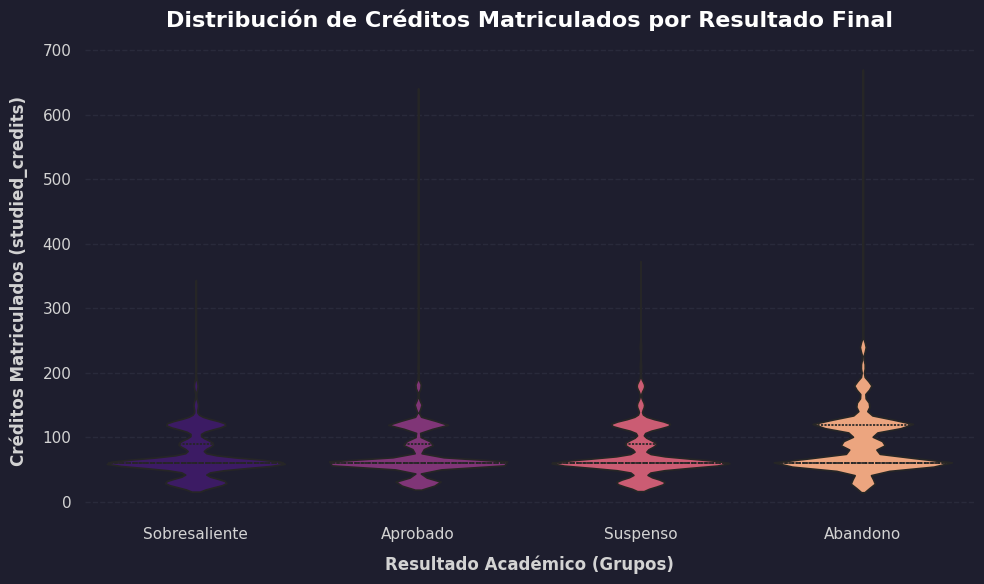

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración Estética (Modo Oscuro)
plt.style.use('dark_background')
plt.rcParams.update({
    "figure.facecolor": "#1e1e2e", "axes.facecolor": "#1e1e2e",
    "grid.color": "#45475a", "axes.edgecolor": "#585b70",
    "text.color": "white", "axes.labelcolor": "lightgray", 
    "xtick.color": "lightgray", "ytick.color": "lightgray"
})

# Aseguramos la traducción si no se ha hecho en la celda actual
translation_map = {'Pass': 'Aprobado', 'Distinction': 'Sobresaliente', 'Fail': 'Suspenso', 'Withdrawn': 'Abandono'}
if 'Resultado' not in df_students.columns:
    df_students['Resultado'] = df_students['final_result'].map(translation_map)

orden_resultado = ['Sobresaliente', 'Aprobado', 'Suspenso', 'Abandono']

# Creamos la figura
plt.figure(figsize=(10, 6))

# Usamos un gráfico de violín para ver la densidad de créditos por cada grupo final
ax = sns.violinplot(
    data=df_students, 
    x='Resultado', 
    y='studied_credits', 
    palette='magma', 
    order=orden_resultado,
    inner='quartile' # Muestra las líneas de los cuartiles por dentro
)

# Retoques estéticos
plt.title("Distribución de Créditos Matriculados por Resultado Final", 
          fontsize=16, fontweight='bold', pad=15, color='white')
plt.xlabel("Resultado Académico (Grupos)", 
           fontsize=12, fontweight='bold', labelpad=10)
plt.ylabel("Créditos Matriculados (studied_credits)", 
           fontsize=12, fontweight='bold', labelpad=10)

plt.grid(axis='y', linestyle='--', alpha=0.3)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()
